# Set Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 작업할 공간 설정
import os
os.chdir('/content/drive/MyDrive/ProcessTransformer') #  작업할 path를 현재 path로 변경

In [ ]:
!pip install wget
!pip install processtransformer
!pip install shap

In [ ]:
!python --version
import tensorflow as tf
print("Tensorflow ", tf.__version__)

Python 3.10.12
Tensorflow  2.15.0


In [ ]:
import argparse
import json
import numpy as np
import pandas as pd

from processtransformer import constants
from processtransformer.models import transformer
from processtransformer.data.loader import LogsDataLoader
from processtransformer.data.processor import LogsDataProcessor

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import shap

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
parser = argparse.ArgumentParser(
    description="Process Transformer - Data Processing.")
parser.add_argument("--dataset",
    type=str,
    default="BPIC12_cw",
    help="dataset name")
parser.add_argument("--dir_path",
    type=str,
    default="./datasets",
    help="path to store processed data")
parser.add_argument("--raw_log_file",
    type=str,
    default="/content/drive/MyDrive/BPIData/BPI_Challenge_2012cw.csv",
    help="path to raw csv log file")
parser.add_argument("--task",
    type=constants.Task,
    default=constants.Task.NEXT_ACTIVITY,
    help="task name")
parser.add_argument("--sort_temporally",
    type=bool,
    default=False,
    help="sort cases by timestamp")
parser.add_argument("--epochs",
    type=int,
    default=100,
    help="number of totla epochs")
parser.add_argument("--batch_size",
    type=int,
    default=64, # 32, 64, 128, 256
    help="batch size")
parser.add_argument("--learning_rate",
    type=float,
    default=0.001,
    help="learning_rate")

args = parser.parse_args(args=[])

result_path = f"{args.dir_path}/results"
model_path = f"{args.dir_path}/models"

# Data Processing

In [ ]:
# Data Processing
data_processor = LogsDataProcessor(name=args.dataset,
        filepath=args.raw_log_file,
        columns = ["Case ID", "Activity", "Complete Timestamp"], #["case:concept:name", "concept:name", "time:timestamp"],
        dir_path=args.dir_path, pool = 1) #changed from 4 to 1

data_processor.process_logs(task=args.task, sort_temporally= False)

In [ ]:
# Load Data
data_loader = LogsDataLoader(name = args.dataset)

(train_df, test_df, x_word_dict, y_word_dict, max_case_length,
    vocab_size, num_output) = data_loader.load_data(args.task)

# Prepare training examples for next time prediction task
train_token_x, train_token_y= data_loader.prepare_data_next_activity(train_df,
    x_word_dict, y_word_dict, max_case_length)

# Training the Model

In [ ]:
# Create and train a transformer model
import tensorflow as tf

transformer_model = transformer.get_next_activity_model(
    max_case_length=max_case_length,
    vocab_size=vocab_size,
    output_dim=num_output)

transformer_model.compile(optimizer=tf.keras.optimizers.Adam(args.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

results = transformer_model.fit(train_token_x, train_token_y,
    epochs=10, batch_size=args.batch_size)

Epoch 1/10
804/804 [==============================] - 95s 114ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.7352
Epoch 2/10
804/804 [==============================] - 85s 105ms/step - loss: 0.5059 - sparse_categorical_accuracy: 0.7849
Epoch 3/10
804/804 [==============================] - 86s 107ms/step - loss: 0.4986 - sparse_categorical_accuracy: 0.7856
Epoch 4/10
804/804 [==============================] - 85s 106ms/step - loss: 0.4961 - sparse_categorical_accuracy: 0.7874
Epoch 5/10
804/804 [==============================] - 87s 108ms/step - loss: 0.4941 - sparse_categorical_accuracy: 0.7881
Epoch 6/10
804/804 [==============================] - 84s 105ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.7884
Epoch 7/10
804/804 [==============================] - 86s 107ms/step - loss: 0.4923 - sparse_categorical_accuracy: 0.7878
Epoch 8/10
804/804 [==============================] - 87s 108ms/step - loss: 0.4908 - sparse_categorical_accuracy: 0.7890
Epoch 9/10
804/804 [====

In [ ]:
# Evaluate over all the prefixes (k)
k, accuracies,fscores, precisions, recalls = [],[],[],[],[]
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"]==i]
    if len(test_data_subset) > 0:
        test_token_x, test_token_y = data_loader.prepare_data_next_activity(test_data_subset,
            x_word_dict, y_word_dict, max_case_length)
        y_pred = np.argmax(transformer_model.predict(test_token_x), axis=1)
        accuracy = metrics.accuracy_score(test_token_y, y_pred)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            test_token_y, y_pred, average="weighted")
        k.append(i)
        accuracies.append(accuracy)
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)

k.append(i + 1)
accuracies.append(np.mean(accuracy))
fscores.append(np.mean(fscores))
precisions.append(np.mean(precisions))
recalls.append(np.mean(recalls))

1/1 [==============================] - 0s 27ms/step


In [ ]:
print('Average accuracy across all prefixes:', np.mean(accuracies))
print('Average f-score across all prefixes:', np.mean(fscores))
print('Average precision across all prefixes:', np.mean(precisions))
print('Average recall across all prefixes:', np.mean(recalls))

Average accuracy across all prefixes: 0.8113207917321797
Average f-score across all prefixes: 0.793179410327231
Average precision across all prefixes: 0.8049352348348076
Average recall across all prefixes: 0.8069329031678119


# Save the Result

In [ ]:
# Save the results
results_df = pd.DataFrame({"k":k, "accuracy":accuracies, "fscore": fscores,
    "precision":precisions, "recall":recalls})
results_df.to_csv(result_path+"_next_activity.csv", index=False)

# XAI SHAP

In [ ]:
# Prepare test examples for next time prediction task
test_token_x, test_token_y= data_loader.prepare_data_next_activity(test_df,
    x_word_dict, y_word_dict, max_case_length)

background = train_token_x[np.random.choice(train_token_x.shape[0], 50, replace=False)]
print(len(background[0]))

explainer = shap.KernelExplainer(transformer_model, background)

x_test = test_token_x[np.random.choice(test_token_x.shape[0], 50, replace=False)]
# x_test = test_token_x[:100]
shap_values = explainer.shap_values(x_test)


50


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
classNumber = 0
class_name = list(y_word_dict.keys())
print(len(shap_values))

6


In [ ]:
y_word_dict

{'w_completeren-aanvraag-complete': 0,
 'w_nabellen-offertes-complete': 1,
 'w_valideren-aanvraag-complete': 2,
 'w_afhandelen-leads-complete': 3,
 'w_nabellen-incomplete-dossiers-complete': 4,
 'w_beoordelen-fraude-complete': 5}

In [ ]:
feature_name=[]
for i in range(0, max_case_length):
  feature_name.append(f"Act {i + 1}")

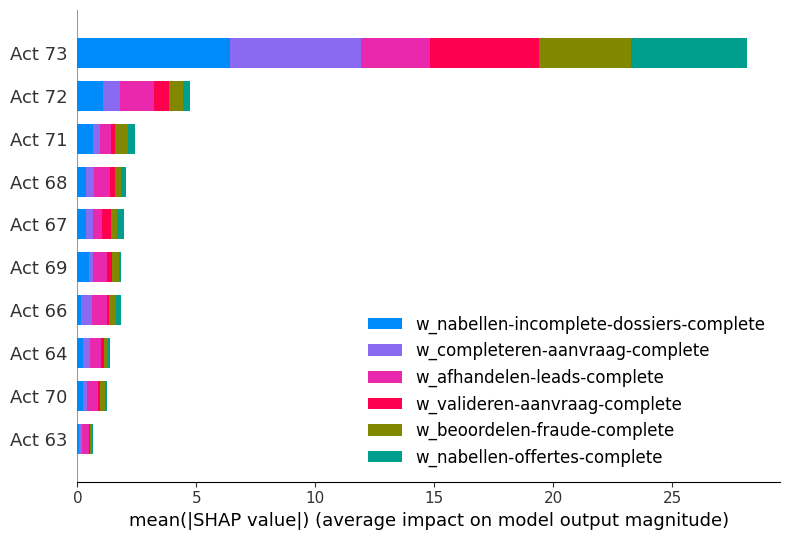

In [ ]:
shap.summary_plot(shap_values,
                  x_test,
                  plot_type="bar",
                  max_display=10,
                  class_names=class_name,
                  feature_names=feature_name)


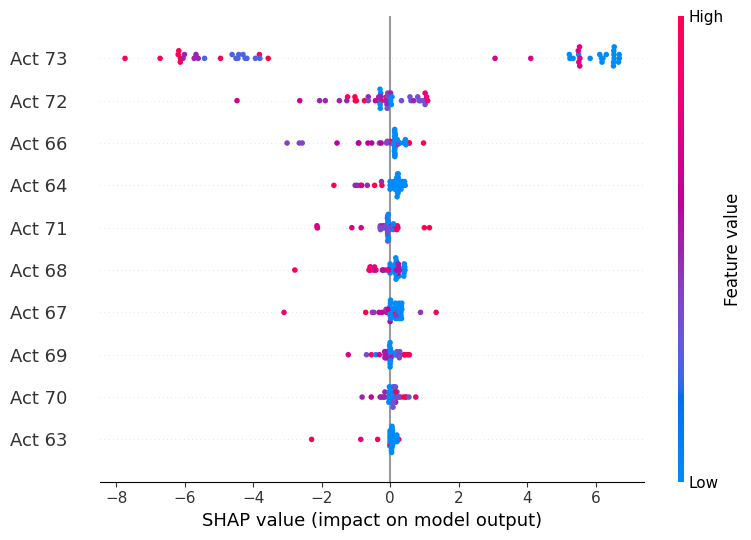

In [ ]:
# Shap value와 X인자 간 상관관계, X인자가 예측에 어떤 방향으로 영향을 미쳤는지 파악 가능
f = plt.figure()
shap.summary_plot(shap_values[classNumber],
                  x_test,
                  max_display=10,
                  class_names=class_name,
                  feature_names=feature_name)

<Figure size 640x480 with 0 Axes>

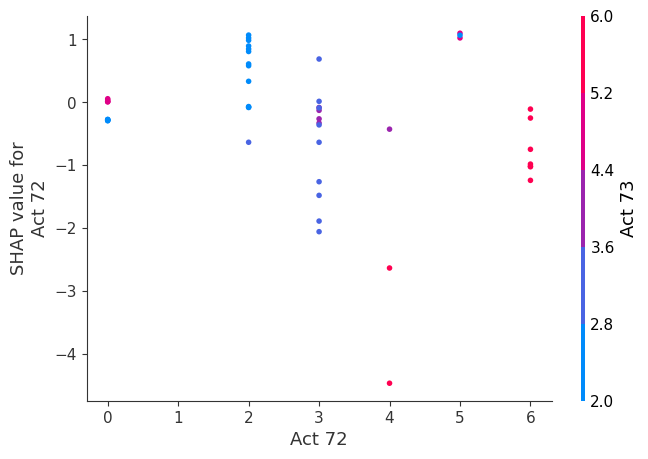

In [ ]:
f = plt.figure()
shap.dependence_plot(71, shap_values[classNumber], x_test, feature_names=feature_name)

In [ ]:
# 전체 데이터에 대한 Shapley Value를 누적 & 시각화
shap.initjs()
force = shap.force_plot(explainer.expected_value[classNumber],
                shap_values[classNumber],
                x_test,
                feature_names=feature_name)

from IPython.display import HTML
HTML(f"<div style='background-color:white;'>{shap.getjs() + force.html()}</div>")
shap.save_html('my_force_plot.html', force)

In [ ]:
# This code example demonstrates how to convert HTML document to PNG images.
import aspose.words as aw

# Load an existing Word document
doc = aw.Document("/content/drive/MyDrive/ProcessTransformer/my_force_plot.html")

# Specify image save options
# Set save format as PNG
imageOptions = aw.saving.ImageSaveOptions(aw.SaveFormat.PNG)

# Change the image's brightness and contrast.
# Both are on a 0-1 scale and are at 0.5 by default.
imageOptions.image_brightness = 0.3
imageOptions.image_contrast = 0.7

# Save the pages as PNG
for page in range(0, doc.page_count):
    extractedPage = doc.extract_pages(page, 1)
    extractedPage.save("./force_plot.png", imageOptions)

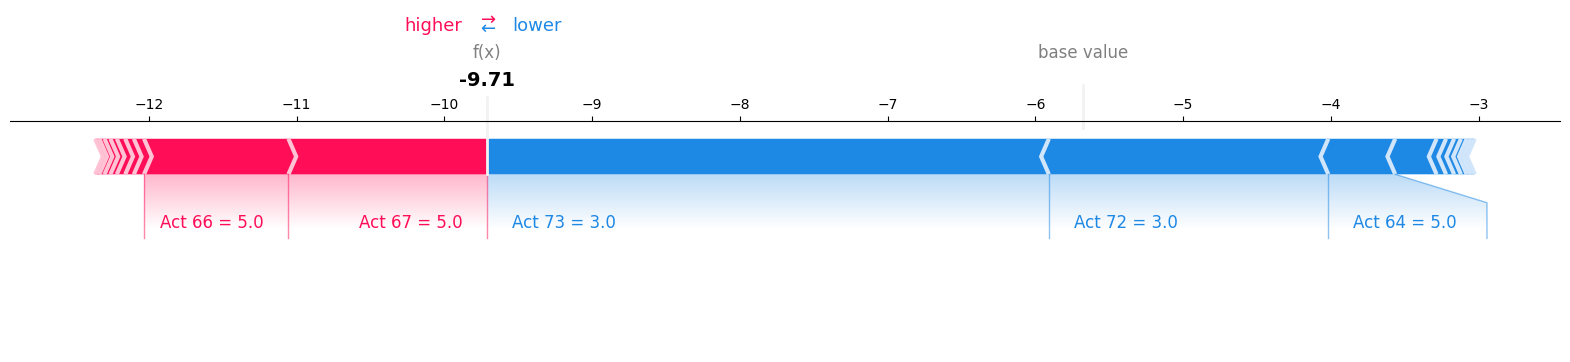

In [ ]:
# 다수의 기능 효과 표시
# 특정 데이터 하나 & 전체 데이터에 대해 Shapley Value를 1차원 평면에 정렬
shap.initjs()
shap.plots.force(explainer.expected_value[classNumber],
                 shap_values[classNumber][0, :],
                 x_test[0, :],
                 matplotlib = True,
                 feature_names=feature_name)

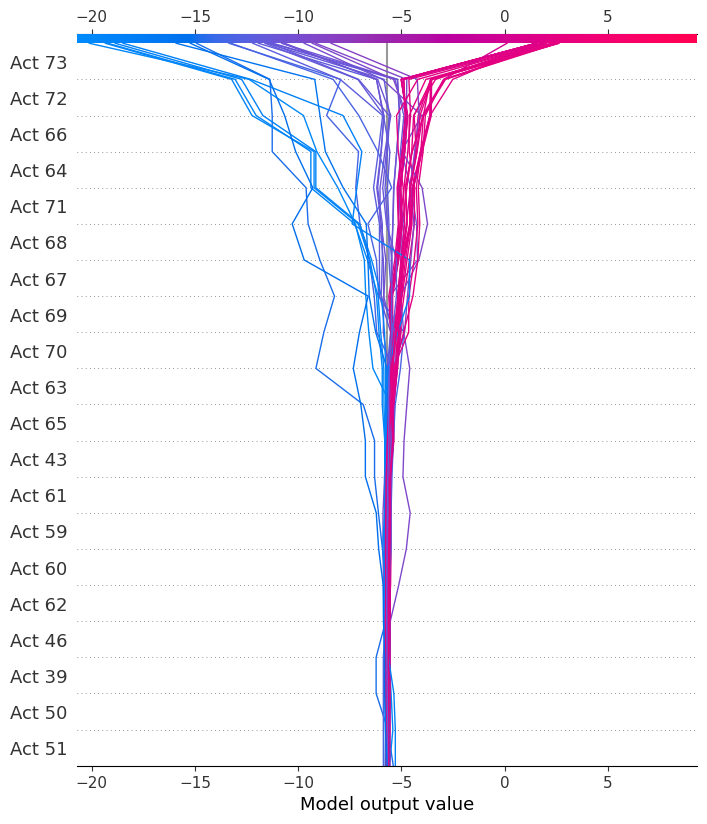

In [ ]:
shap.decision_plot(explainer.expected_value[classNumber],
                   shap_values[classNumber],
                   x_test,
                   feature_names=feature_name)